In [21]:
import numpy as np
import operator
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


## Reading dataset  
[Dataset link](https://www.kaggle.com/arhamrumi/amazon-reviews-eda-20012018)  
&nbsp;


In [22]:
sports = pd.read_csv("Sports_and_Outdoors.csv")
sports.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12969732 entries, 0 to 12969731
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   rating      int64 
 1   verified    bool  
 2   reviewerID  object
 3   product_id  object
 4   date        int64 
 5   vote        object
dtypes: bool(1), int64(2), object(3)
memory usage: 507.1+ MB


### Dropping columns not used for analysis
&nbsp;

In [23]:
sports.drop(['verified', 'vote'], axis=1, inplace=True)
sports = sports.sort_values('date', ascending=False)
sports.head()


,rating,reviewerID,product_id,date
12968859,3,AAL07KPFE0VFI,B01HIT0QDG,1538697600
12969474,5,A39ANO7WWQ9PE8,B01HJA3STS,1538697600
12969475,5,A4HCTG3TV7UPM,B01HJA3STS,1538611200
12969105,1,A30DF0WFD9U1PT,B01HIY7NPU,1538611200
12965742,5,A2WCAIO2XACZ01,B01HGSLB6K,1538611200


In [24]:
products = sports['product_id'].unique()
users = sports['reviewerID'].unique()
print('Number of unique products', len(products))
print('Number of unique users', len(users))


Number of unique products 957764
Number of unique users 6703391


&nbsp;
* Making a dictionary to store all ratings given by users to a particular product  
&nbsp;

In [25]:
all_products = defaultdict(dict)
for ind in sports.itertuples():
    all_products[ind.product_id][ind.reviewerID] = ind.rating
all_products = dict(all_products)


&nbsp;
* Removing all products for which only 1 rating has been given   
&nbsp;


In [26]:
new_all = defaultdict(dict)
product_id_nottake = set()
for i, val in all_products.items():
    if len(val) > 1:
        new_all[i] = val.copy()
    else:
        product_id_nottake.add(i)
new_all = dict(new_all)
all_products = new_all


&nbsp;
* Making a dictionary to store all ratings given to products by a particular user  
(Note that the products which had only 1 rating will not be reflected in this dictionary)   
&nbsp;

In [27]:
all_users = defaultdict(dict)
for ind in sports.itertuples():
    if ind.product_id not in product_id_nottake:
        all_users[ind.reviewerID][ind.product_id] = ind.rating
all_users = dict(all_users)


&nbsp;
## Making the data centered around zero

> This is a preprocessing step which helps us in computing the **Pearson correlation**.   

$\Large r =\Large\frac{\Large\sum\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sqrt{\Large\sum\left(x_{i}-\bar{x}\right)^{2} \sum\left(y_{i}-\bar{y}\right)^{2}}}$  

$r = $ Correlation coefficient  
$ x_{i} = $	values of the x-variable in a sample  
$\bar{x} = $	mean of the values of the x-variable  
$ y_{i} = $	values of the y-variable in a sample  
$\bar{y} = $	mean of the values of the y-variable  

We assume that a value of zero is given to all the products for which ratings haven't been given by a particular user.Thus, the set of all ratings for a given user can now be considered as a vector.  
&nbsp;

In [28]:
epsilon = 1e-6
normalized_products = defaultdict(dict)
for i, val in all_products.items():
    normalized_products[i] = val.copy()
for i, val in normalized_products.items():
    values = list(val.values())
    mean_val = np.mean(values)
    for j in val:
        val[j] -= mean_val


&nbsp;
* For the each of the vectors defined in the previous step, we find the magnitudes.  
&nbsp; 

In [29]:
magnitudes = defaultdict(dict)

for i in normalized_products:
    values = list(normalized_products[i].values())
    magnitudes[i] = np.sqrt(np.sum(np.square(values)))


### TODO:

In [30]:
user = sports['reviewerID'].value_counts().idxmax()
sample_user = user
sample_user


'A3OXHLG6DIBRW8'

&nbsp;
* Getting all the products which have more than 1 rating and which have not been rated by the selected user.  
&nbsp;

In [31]:
rest = list(set(all_products.keys()) - set(all_users[sample_user]))


&nbsp;
* Choosing random 1000 products out of the list generated in the previous step  
&nbsp;

In [32]:
random1000 = np.random.choice(rest, size=1000)


&nbsp;
*  Getting the list of all products for which ratings have been given by the sample user.  
&nbsp;

In [33]:
compare_with = list(all_users[sample_user])


&nbsp;
For each of the products among the 1000 that we chose randomly, we try to predict the ratings which would have been given by the sample user. In order to acheive this, we find the similarity coefficient between the product whose rating is to be predicted, and all those products for which ratings have already been given by the sample user. Once we have the similarity coefficients, we predict the rating for that particular product using the formula :

$ \Large R(u, j) = \Large\frac{\Large\sum\limits_{i \ \epsilon \ compare \_ with} S_{ij} \ . \ R(u, i)}{\Large\sum S_{ij}} $  
&nbsp;

In [34]:
prediction_dict = defaultdict(dict)

for item in random1000:
    sine, calc = dict(), []
    for rated in compare_with:
        if rated not in magnitudes:
            continue
        coeff = 0
        for user in normalized_products[item]:
            if user not in normalized_products[rated]:
                continue
            coeff += normalized_products[item][user] * \
                normalized_products[rated][user]
        if magnitudes[rated] == 0 and magnitudes[item] == 0:
            sine[rated] = 1
        elif magnitudes[rated] == 0 or magnitudes[item] == 0:
            sine[rated] = 0
        else:
            sine[rated] = coeff / (magnitudes[rated] * magnitudes[item])

    coeffs = list()

    sorted_sine = dict(
        sorted(sine.items(), key=operator.itemgetter(1), reverse=True))
    maxrange = min(len(sorted_sine.values()), 100)
    for i in sine:
        if sine[i] <= 0:
            continue
        calc.append(sine[i] * all_users[sample_user][i])
        coeffs.append(sine[i])
        maxrange -= 1
        if maxrange == 0:
            break
    if len(coeffs) == 0:
        continue
    prediction_dict[item] = sum(calc) / sum(coeffs)


&nbsp;
Making a Data Frame having the products which the sample user has not rated yet, and the predicted rating value for the same.    
&nbsp;

In [35]:
# now we will pick top 100 items to recommend to user
prediction_df = pd.DataFrame(prediction_dict.items(), columns=[
                             "product_id", "predicted_rating"])
prediction_df.head()


,product_id,predicted_rating
0,B00AX62PF4,4.857143
1,B00AZHFHXI,4.857143
2,B0041RGOYO,4.857143
3,B010NM0E28,4.442394
4,B00280CIEG,4.857143


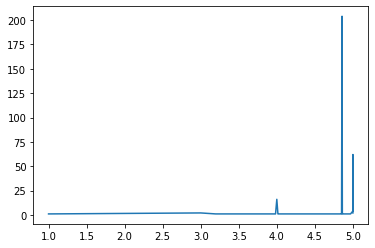

In [36]:
histogram = dict()
for i in prediction_df.itertuples():
    if i.predicted_rating not in histogram:
        histogram[i.predicted_rating] = 1
    else:
        histogram[i.predicted_rating] += 1
bar = sorted(histogram.items())
x, y = zip(*bar)
plt.plot(x, y)
plt.show()


In [37]:
results = prediction_df.sort_values(by="predicted_rating", ascending=False)
recommended_products = list()
for i in range(100):
    recommended_products.append(results.iloc[i]['product_id'])
print("Top 100 Recommended products for user " + str(sample_user) + " -")
for i in recommended_products:
    print(i)


Top 100 Recommended products for user A3OXHLG6DIBRW8 -
B00UA2A07Q
B00WTQ7TKW
B000V032MM
B00I6ICMS6
B004JKIU2M
B000STIDKC
B005LHGCKE
B00OCRND2O
B00M0Z4N38
B007ZRYYWQ
B00ITDFI02
B01FVKT1OE
B001QTLN0U
B00HJA907I
B00APLBBC0
B00DUS5L58
B01DWKLN8C
B0197DABAO
B00T34P68U
B0068HYXPC
B013VP9LWI
B00266D41S
B00AK6Y4TW
B00TENLUAS
B015NMQTG8
B00IQ9IM1Q
B018DLSV3A
B001OPD7SC
B001T7D2Z8
B005ZENO2C
B004UHCNF4
B00ATLCE22
B00EZ9UHFK
B0082MO4O6
B012HPCTUE
B001KWIBZ8
B01FN68G88
B00GJ5F2OO
B007ZH8FCG
B00EFDZUUS
B00588OCPI
B001CM3X68
B004CSZ650
B00CMHHMCI
B001NCDCPY
B00L2R3EAI
B004CZ1MOM
B0026N2X7M
B019IH688I
B00029A7C0
B0010FW6JW
B001T7JWCU
B001PR0MP0
B012NR7XT8
B00EMG53Q4
B01D83816K
B013JACZ78
B00YQ6UMM0
B003369Q9Y
B00Q9ML4RG
B0010F129W
B00891A0S4
B0037AKB18
B001HACRBW
B008FYDVAO
B0036N2UMY
B0060YB5ZE
B0053OQLFG
B001AQ7QSW
B00EWK00EA
B00143PFZ2
B00NUXZDFG
B00BAHWWDA
B010W0I7O8
B001608OMO
B017Y5ISWU
B00IGIRVP0
B01CZV7HSY
B013G4TZ16
B0018OKCU0
B005Z851QK
B016M0JH96
B007CPV1W2
B001RN475I
B00E92CE1S
B00ASJ80E6